In [7]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

print(tf.__version__)

1.15.0


1. This model is inspired by the article on Medium: 
https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
2. The task is treated as a document classification task where the input is the entity pair and sorrounding context, the label to be predicted is the relation type
3. Example: 
- entity1: information retrieval techniques,
- entity2: keywords, 
- label=USAGE 
- entity1 with context: traditional information retrieval techniques use a
- entity2 with context: histogram of keywords as the 
- input: traditional information retrieval techniques use a histogram of keywords as the 
- label: USAGE

In [8]:
import pickle
import pandas as pd
import numpy as np

In [9]:
#import the pickeled file prepared for training the model. 
#it consists of the pair of entities with the sorrounding context of both entities and the label for each pair. 
map_labels = pd.read_pickle("train.pkl")
map_labels.head()

entity_pair          label
0  database traditional information retrieval tec...          USAGE
1  representation but oral communication may offe...          USAGE
2  a large database of tv database of tv shows em...     PART_WHOLE
3  of a distributed message-passing infrastructur...  MODEL-FEATURE
4  laboratory) the cclinc korean-to-english trans...     PART_WHOLE

We map the entity types to numerical value because some of entity types like PART_WHOLE and MODEL-FEATURE consists of two tokens. This couses a problem because the model expects a 1-Dimensional vector for the label but if we have two tokens for some labels the representation for these will be a matrix with 2 dimensions. 

In [10]:
labels = map_labels['label']

In [11]:
# Convert the label from string into a numerical value
for index, item in enumerate(labels):
    if item == 'USAGE':
        labels[index]=0
    if item == 'PART_WHOLE':
        labels[index]=1
    if item == 'MODEL-FEATURE':
        labels[index]=2
    if item == 'RESULT':
        labels[index]=3
    if item == 'COMPARE':
        labels[index]=4
    if item == 'TOPIC':
        labels[index]=5

In [12]:
labels.head()

0    0
1    0
2    1
3    2
4    1
Name: label, dtype: object

In [13]:
map_labels.head()

entity_pair label
0  database traditional information retrieval tec...     0
1  representation but oral communication may offe...     0
2  a large database of tv database of tv shows em...     1
3  of a distributed message-passing infrastructur...     2
4  laboratory) the cclinc korean-to-english trans...     1

1. Vocabulary size is the size of the vocabulary that we created in previous steps.
2. Choose and embedding dimension of 64.
3. According to some statistical analysis we made with the dataset, the maximum lenght of sequences is:  27 and the minimum 7. while the average sequence lngth is 12.46 and the median is 12. So we decided to have a maximum length of the sequence equal to 12. 
4. Do padding for sequences smaller than 12 and trucating for sequences larger than 12. 
5. oov_token stands for tokens which are not found in the vocabulary. 
6. Decide 80% of the data for training and 20% validation. 

In [14]:
vocab_size = 4297
embedding_dim = 64
max_length = 12
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [15]:
#create two lists for holding entity pair and labels.
entities = []
labels = []

In [16]:
for row in map_labels['entity_pair']:
    entities.append(row)
    
for label in map_labels['label']:
    labels.append(label)

In [17]:
#we get 982 samples for training and 246 sample for validation
train_size = int(len(entities) * training_portion)

train_entities = entities[0: train_size]
train_labels = labels[0: train_size]

validation_entities = entities[train_size:]
validation_labels = labels[train_size:]

In [18]:
#Here we show the index of the tokens present in the training data after tokenization.
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_entities)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:15])

{'<OOV>': 1,
 'the': 2,
 'of': 3,
 'a': 4,
 'in': 5,
 'and': 6,
 'for': 7,
 'to': 8,
 'based': 9,
 'on': 10,
 'from': 11,
 'is': 12,
 'with': 13,
 'that': 14,
 'word': 15}

1. In this part we make some statistical calculations that will help us decide for the maximum sequence length. 
2. Based on the below computations we decide for maximum sequence length = 12

In [19]:
len_seq = []
train_sequences = tokenizer.texts_to_sequences(train_entities)
for i in range (len(train_sequences)):
    len_seq.append(len(train_sequences[i]))

def Average(lst): 
    return sum(lst) / len(lst) 

In [20]:
import statistics 
print('The maximum sequence length is: ', max(len_seq))
print('The minimum sequence length is: ', min(len_seq))
print('The average length of the squence is: ', Average(len_seq)) 
print('The median length of the squence is: ', statistics.median(len_seq)) 

The maximum sequence length is:  27
The minimum sequence length is:  7
The average length of the squence is:  12.505091649694501
The median length of the squence is:  12.0


In [21]:
#Some examples after padding the sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(train_padded.shape)
type(train_padded)

12
12
11
12
(982, 12)


numpy.ndarray

In [22]:
#an example of the training data expresed with word indices. 
print(train_padded[1])

[  86  228 1232  315  437  808  808  438 1233   64   21    0]


In [23]:
#246 samples for validation with sequence length 12
validation_sequences = tokenizer.texts_to_sequences(validation_entities)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

246
(246, 12)


In [24]:
# Split train and validation labels
train_labels = pd.array(train_labels)
train_labels = train_labels.to_numpy()
print(train_labels[:20])
validation_labels = pd.array(validation_labels)
validation_labels = validation_labels.to_numpy()
print(validation_labels[200:246])
type(train_labels)

[0 0 1 2 1 0 2 0 0 2 1 3 3 3 0 3 2 2 0 0]
[4 2 4 2 0 4 0 2 2 0 0 0 1 1 1 2 1 1 2 2 0 2 1 1 1 0 2 2 3 0 1 0 2 1 5 2 0
 2 2 1 2 2 3 1 0 0]


numpy.ndarray

In [25]:
train_labels.shape

(982,)

In [26]:
model = tf.keras.Sequential([
    # Add an Embedding layer, input is the vocab of size , and output embedding dimension decided at the begining. 
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    #Choose a bidirectional LSTM layer to better capture the context.  
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    # use ReLU as an activation function
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    tf.keras.layers.Dense(6, activation='softmax')
])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          275008    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (N

In [27]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, train_labels, epochs=num_epochs, validation_data=(validation_padded, validation_labels), verbose=2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 982 samples, validate on 246 samples
Epoch 1/10
982/982 - 15s - loss: 1.6190 - acc: 0.3992 - val_loss: 1.4886 - val_acc: 0.3374
Epoch 2/10
982/982 - 5s - loss: 1.3689 - acc: 0.4094 - val_loss: 1.4243 - val_acc: 0.3618
Epoch 3/10
982/982 - 5s - loss: 1.1374 - acc: 0.5071 - val_loss: 1.6405 - val_acc: 0.4634
Epoch 4/10
982/982 - 5s - loss: 0.8257 - acc: 0.6527 - val_loss: 1.4693 - val_acc: 0.4756
Epoch 5/10
982/982 - 5s - loss: 0.5666 - acc: 0.7587 - val_loss: 1.7685 - val_acc: 0.4715
Epoch 6/10
982/982 - 5s - loss: 0.3372 - acc: 0.8676 - val_loss: 2.2716 - val_acc: 0.4878
Epoch 7/10
982/982 - 5s - loss: 0.2088 - acc: 0.9104 - val_loss: 2.4571 - val_acc: 0.5000
Epoch 8/10
982/982 - 7s - loss: 0.1585 - acc: 0.9318 - val_loss: 2.8501 - val_acc: 0.4756
Epoch 9/10
982/982 - 5s - loss: 0.1353 - acc: 0.9409 - val_loss: 2.9439 - val_acc: 0.4472
Epoch 10/10
982/982 - 7s - loss: 0.0960 - acc: 0.

In [28]:
import matplotlib.pyplot as plt

In [29]:
def plot_graphs(history, string):
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

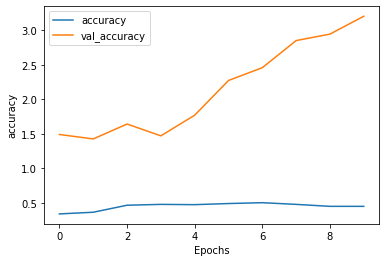

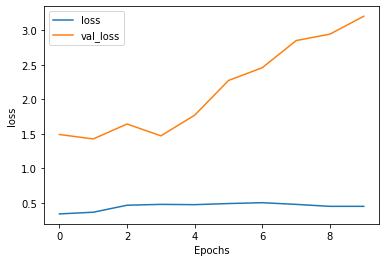

In [30]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Testing the Model

In [31]:
test_data = pd.read_pickle("test_pair.pkl")
test_data.head()

test_pair       label
0  labeling (srl) arguments are usually in a synt...  PART_WHOLE
1  to label arguments locally in such a sub-tree ...  PART_WHOLE
2  approach the anchor group approach achieves an...      RESULT
3  that the prediction of mp improves semantic mp...      RESULT
4  of a multilingual translation system based on ...       USAGE

In [45]:
# Do the same as in training data, convert labels into numerical
test_labels = test_data['label']

In [46]:
for index, item in enumerate(test_labels):
    if item == 'USAGE':
        test_labels[index]=0
    if item == 'PART_WHOLE':
        test_labels[index]=1
    if item == 'MODEL-FEATURE':
        test_labels[index]=2
    if item == 'RESULT':
        test_labels[index]=3
    if item == 'COMPARE':
        test_labels[index]=4
    if item == 'TOPIC':
        test_labels[index]=5

In [51]:
test_labels = []
test_entities = []

In [52]:
for t_label in test_data['label']:
    test_labels.append(t_label)
for test in test_data['test_pair']:
    test_entities.append(test)

In [53]:
test_labels = pd.array(test_labels)
test_labels = test_labels.to_numpy()

In [34]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(test_entities)

In [35]:
test_sequences = tokenizer.texts_to_sequences(test_entities)

In [36]:
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [37]:
model.predict(test_padded)

array([[1.0736084e-01, 1.1201582e-03, 8.9147902e-01, 2.7135178e-07,
        3.9671155e-05, 7.5878477e-09],
       [9.6086186e-04, 1.7080486e-03, 9.9727291e-01, 5.3242530e-07,
        5.7579615e-05, 2.3437707e-08],
       [1.2229873e-04, 1.8630573e-03, 9.9677116e-01, 2.8508961e-05,
        1.2148090e-03, 1.4327468e-07],
       ...,
       [3.0493242e-01, 1.6254431e-03, 6.9343185e-01, 2.6138609e-08,
        1.0191110e-05, 1.1207771e-09],
       [6.8708247e-04, 9.4443220e-01, 4.4518612e-02, 6.5623222e-05,
        1.0219705e-02, 7.6771095e-05],
       [9.9999976e-01, 9.6748408e-08, 1.3676828e-07, 7.3377754e-12,
        4.9087584e-10, 6.5751617e-14]], dtype=float32)

In [54]:
score = model.evaluate(test_padded, test_labels, verbose = 0)

In [56]:
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 4.61424136900566 / Test accuracy: 0.31830987334251404


In [38]:
a = model.predict(test_padded)

In [39]:
type(a)

numpy.ndarray

In [40]:
print(a[0])
type(a[0])

[1.0736084e-01 1.1201582e-03 8.9147902e-01 2.7135178e-07 3.9671155e-05
 7.5878477e-09]


numpy.ndarray

In [41]:
b = [a[i].tolist() for i in range(len(a))]

In [43]:
blstm_output = pd.DataFrame(b)
blstm_output.to_pickle('blstm_predictions.pkl')